# Tranining model

There are many model to be trained in this chapter:

- Use the text feature to predict the price of the product.
- Find which factors influnce the price of the product most.
- Use the product factors to predict the ranking of the product

In [151]:
%matplotlib inline 
import numpy as np
import pandas as pd # for data analysis
import matplotlib.pyplot as plt # for plotting
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LogisticRegressionCV, RidgeCV
from sklearn.metrics import classification_report
from PIL import Image
import requests
from io import BytesIO

In [2]:
pens_df = pd.read_csv("clean_fountain_pen_dataset.csv").drop(["Unnamed: 0"],axis=1)
pens_df.head()

,url,Product_Code,Name,In_Stock,Price,Nib_Size,Brand,Color,Demonstrator,Body_Material,...,Max_Ink_Capacity_Converter,Max_Ink_Capacity_Eyedropper,Cap_Rotations,created_at,description,featured_image,images,published_at,clean_description,Series
0,https://www.gouletpens.com/collections/all-fou...,Plat-PSQ-400-01-1,Platinum Preppy Fountain Pen - Black,True,5.00,"Extra-Fine, Fine, Medium",Platinum,Black,Yes,Resin,...,0.98,4.33,NaN,2018-05-02 10:28:05-04:00,\nThe Platinum Preppy fountain pen is one of t...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,one best value money fantastic starter great l...,Preppy
1,https://www.gouletpens.com/collections/all-fou...,PN91111,Pilot Metropolitan Fountain Pen - Black Plain,True,23.99,"Fine, Medium, 1.0mm Stub",Pilot,Black,No,Lacquered metal,...,1.30,NaN,NaN,2018-05-02 10:28:13-04:00,"\nA fantastic value from Pilot, the Metropolit...",//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,fantastic value favorite first black metal bod...,Metropolitan
2,https://www.gouletpens.com/collections/all-fou...,TW-M7445300,TWSBI ECO Fountain Pen - Clear,True,28.99,"Extra-Fine, Fine, Medium, Broad, 1.1mm Stub",TWSBI,Clear,Yes,Resin,...,NaN,NaN,1.00,2018-05-02 10:28:24-04:00,\r\n The TW...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,boast incredible value piston filling system a...,ECO
3,https://www.gouletpens.com/collections/all-fou...,N15021,Noodler's Ahab Flex Fountain Pen - Clear,True,23.00,Flex,Noodler's,Clear,Yes,Resin,...,NaN,6.17,2.25,2018-05-02 10:25:05-04:00,\r\n The No...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,noodler 's ahab flex feature steel flexible 6 ...,Ahab Flex
4,https://www.gouletpens.com/collections/all-fou...,Plat-PSQ-400-03-1,Platinum Preppy Fountain Pen - Blue,True,4.98,"Extra-Fine, Fine, Medium",Platinum,Blue,Yes,Resin,...,0.98,4.33,NaN,2018-05-02 10:28:06-04:00,\nThe Platinum Preppy fountain pen is one of t...,//cdn.shopify.com/s/files/1/2603/2528/products...,['//cdn.shopify.com/s/files/1/2603/2528/produc...,2018-01-01 11:00:00-05:00,one best value money fantastic starter great l...,Preppy


## *Model A*: use the text feature in predicting the price of the product

I want to explore whether the text message does show the pattern of setting price tag. Most of time when we plan to buy a product, we want to check the product discription to see if its really worth to buy. Does the product discription really tell us something important, distinguishable from other product? I doubt this as I always have trouble to buy a product and may hesitate to make the final decision. So I want to build a model to verify it.

In [22]:
model_A_df = pens_df[pens_df.clean_description.notnull()]
model_A_df[["Price","clean_description"]].sample(5)

,Price,clean_description
523,169.0,made sonoran sunset resin gold-plated clip two...
518,90.0,graphic flamboyant collection feature pattern ...
297,120.0,innovative line strong attitude unmistakably s...
259,68.0,looking combine peak writing performance high-...
143,17.0,new entry-level full-sized faceted body grip m...


### *Response Variable Choice 1*: continuous variable

The price could explicitly give the intuition of how much the product worths.

In [235]:
y = model_A_df.Price

### *Response Variable Choice 2*: discrete variable

The price can be seperated as affordable and unaffordable sometimes, or more intutively with high and low price. That makes sense when we have limited budget.

With domain knowledge, pen lovers always treat the $200 as the boundary between affordable and unaffordable pens.

In [188]:
y = np.where(model_A_df.Price < 200, 1, 0)

### *Explanatory Variable Choice 1*: use the count of each word to build the feature vector

All the stopwords and the feature words for each individual pen have been removed. The count of each word could implicate the importance of the text. 

In [25]:
clean_text = model_A_df.clean_description
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(clean_text)

### *Explanatory Variable Choice 2*: use the tfid features of each word to build the feature vector

The importance of the words will increase while the frequency of words in each text increase. But the importance is also limited by the frequency of word in all the text together. This inverse document frequency method can avoid the penalty of same words occur in multiple texts.

In this dataset, this could effectively lower the occur of technical words of product and concentrate more on the unique discription of each product.

In [236]:
clean_text = model_A_df.clean_description
vectorizer = TfidfVectorizer(min_df=1)
X = vectorizer.fit_transform(clean_text)

### *Explanatory Variable Choice 3*: use PCA to reduce the dimension of the frequency count feature vector

As the frequency count data feature could be highly correlated, we could use PCA to find the principle components and recompute the feature vector to get less correlated data. This is useful for further logistic regression analysis as the logitstic regression can't seperate the correlation of the different predictors as Lasso or Ridge.

In [186]:
clean_text = model_A_df.clean_description
vectorizer = CountVectorizer(min_df=1)
X = vectorizer.fit_transform(clean_text)

pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X.toarray())
print(X.shape)
print(X_pca.shape)
X = X_pca

(653, 3449)
(653, 86)


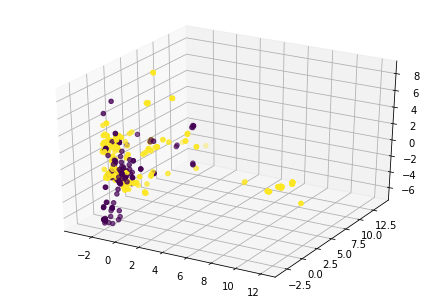

In [28]:
## Try projection with 3D PCA
clean_text = model_A_df.clean_description
vectorizer = CountVectorizer(min_df=5)
X = vectorizer.fit_transform(clean_text)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X.toarray())

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:,0], X_pca[:,1],X_pca[:,2], c=y)

Both the 3D and 2D projection can not seperate the categorical response. Higher dimension is required.

### Split the data

To use train-validate-test validation could cost lots of data in the validate data and test data. The dataset is quite a small dataset. So it's more reasonable to use cross validation method to reuse the data many times to get more information and more precise result.

In [237]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
# val_X, test_X, val_y, test_y = train_test_split(test_X,test_y,test_size=0.5,random_state=1)
# train_X.shape, val_X.shape, test_X.shape

### *Model Fitting Choice 1*: Ridge cross validation model

I ignored the exploration of the linear regression model, because its obvious that, in text data, there is some relation between the words. There should be some pattern such that some words always come after the certain other word. In the transformed feature vector of each text, this behaves as highly coefficients amount the different feature words predictors. So the variable of each predictor could very among different random states and also cause model overfitting.

So, for the continuous response, I choose the Ridge model to add penalty to the coefficient, suppress the co-linearity and get a better prediction.

In [238]:
ridge_reg = RidgeCV(cv=5,alphas=np.linspace(0.001,50,1000))
ridge_reg.fit(train_X,train_y)
ridge_reg.score(test_X,test_y)

/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.8579843712600262

### *Model Fitting Choice 2*: Lasso cross validation model

Different from the Ridge regression, Lasso uses l2 penalty(sum of squares) rather than l1 penalty(absolute value). So Lasso could compute zero coefficient. This property gives it the function to do predictors selection and slove model overfitting.

To check for model overfitting and reduce its effect, the Lasso regression should be applied.

In [239]:
lasso_reg = LassoCV(cv=5,alphas=np.linspace(0.001,50,1000))
lasso_reg.fit(train_X,train_y)
lasso_reg.score(test_X,test_y)

0.8083320216520071

### *Model Fitting Choice 3*: Logistic regression cross validation model

If the response variable is a two-level categorical variable. Logistic regression is applied.

**Parameter setting**

- The C is set to be choosen from 1000 values between 1e-4 and 1e4 by grid search.
- The number of products is far smaller than the number of features, so the dual formulation should be implemented to avoid the lower explanatory functionality of each features. Under this condition, only the "liblinear" solver and ridge penalty could be choosen.

In [20]:
logistic_reg = LogisticRegressionCV(Cs=1000,cv=5,dual=True,penalty="l2",solver="liblinear",max_iter=1000)
logistic_reg.fit(train_X,train_y)
print(logistic_reg.score(test_X,test_y))
predict_y = logistic_reg.predict(test_X)
print(classification_report(test_y,predict_y,target_names=["low_price","high_price"]))

/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9694656488549618
              precision    recall  f1-score   support

   low_price       0.96      0.89      0.93        28
  high_price       0.97      0.99      0.98       103

   micro avg       0.97      0.97      0.97       131
   macro avg       0.97      0.94      0.95       131
weighted avg       0.97      0.97      0.97       131



### *Model Fitting Choice 3*: Logistic regression cross validation model with PCA components

Logistic regression can't handle the correlation between the different components. So using PCA to get principle component should get a better result.

**Parameter setting**

- The C is set to be choosen from 1000 values between 1e-4 and 1e4 by grid search.
- The number of products is greater enough than the number of features under PCA. So we do not need to use the dual choice.
- The Lasso regression is been implemented with the "saga" solver and "l1" penalty.

In [190]:
logistic_reg = LogisticRegressionCV(Cs = 1000,cv=5,max_iter=1000,penalty="l1",solver="saga")
logistic_reg.fit(train_X,train_y)
print(logistic_reg.score(test_X,test_y))
predict_y = logistic_reg.predict(test_X)
print(classification_report(test_y,predict_y,target_names=["low_price","high_price"]))

0.9694656488549618
              precision    recall  f1-score   support

   low_price       0.90      0.96      0.93        28
  high_price       0.99      0.97      0.98       103

   micro avg       0.97      0.97      0.97       131
   macro avg       0.95      0.97      0.96       131
weighted avg       0.97      0.97      0.97       131



/mnt/c/Users/51606/Desktop/Denver/course/2019SP_data_science_tools/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


### Model selection and model application


                                    This Namiki maki-e fountain pen was created by maki-e artisan Seiki in Japan. It features the Togidashi Maki-e technique (burnished maki-e), depicting waves and a plover (a type of sea bird). The pen has an 18kt gold nib (#10), fills via cartridge/converter (a CON-70 is included), and comes packaged in a wooden box with a bottle of ink.The Yukari Collection vividly expresses the nature of the four seasons, which the Japanese have been familiar with since ancient times, by combining designs with various techniques such as Togidashi-Taka Maki-e (Burnished-Raised Maki-e) and Raden (Mother-of-Pearl). While being a size that can be carried and used every day, it harbors Japanese beauty down to the finest detail.As these pens are truly one-of-a-kind pieces of art, they are warrantied for life by Namiki.
                                    
                                
																				
																			


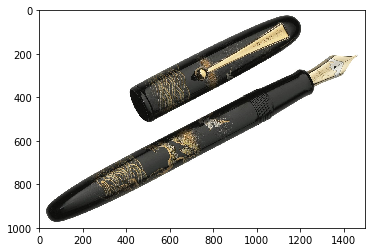

In [229]:
idx = np.random.randint(0,model_A_df.shape[0]-1)
info = model_A_df.loc[idx][["Price","description","featured_image"]]
print(info[1])

response = requests.get("http:"+info[2])
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [232]:
pred_price = lasso_reg.predict(X[idx,])[0]

print("the predicted price is ${}".format(pred_price))
print("The actual price is ${}".format(info[0]))

ValueError: Expected 2D array, got 1D array instead:
array=[-1.84092043e+00 -2.74914815e+00 -4.76951296e+00  4.80151748e+00
 -3.65581911e+00  1.79212358e+00  1.18638613e+00  2.49820368e-01
  1.11422876e+00 -2.61465952e-01  9.11049691e-01 -7.49042285e-01
  6.38643218e-01  4.11401758e-01 -1.24172613e-01 -4.99258439e-02
  6.67969311e-02  8.21916633e-01 -5.32485159e-01 -1.83852039e-01
  5.39771133e-01 -3.42062510e-01  2.41289430e-01  8.29797706e-01
  1.11488518e+00 -9.82026664e-01  6.34364997e-01  3.35426139e-02
 -5.23777305e-01 -5.63260161e-02  1.79553954e+00  1.35985153e+00
 -3.15252187e-01 -1.93424223e+00 -1.64760347e+00 -5.63919410e-01
  3.06330321e-01 -3.83517373e-01  8.59973584e-01 -4.68931821e-01
 -1.35508366e+00  2.07142602e-02  2.33690276e-01 -1.51073854e-01
 -3.63024986e-01 -5.21735715e-01 -5.02066827e-01  1.09007215e+00
  2.37993053e-01 -2.86113276e-01 -6.12924185e-01 -1.86058839e-01
  8.32709372e-02 -8.01944041e-02 -2.14655872e-01 -1.62161689e-01
 -4.77580266e-01 -3.56509905e-01 -7.37790677e-02 -1.41246077e-01
 -4.82755466e-01  7.38302770e-02  5.86459377e-02 -6.55601513e-01
 -6.55435271e-01  1.39973384e-01 -5.40871589e-01 -2.37136384e-01
 -1.05356279e+00  7.39959616e-01 -1.28910452e+00 -3.22883940e-03
 -5.66697124e-01 -1.64132458e-01  4.85083901e-01  6.80978967e-01
  5.31091614e-01  3.12477908e-01 -2.10822604e-01 -8.30465559e-01
 -4.50355672e-01 -1.22649027e-01  4.40159652e-01 -4.95399521e-01
 -3.66417826e-01  7.31936912e-02].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [231]:
pred_label = "low price" if logistic_reg.predict([X[idx,]])[0] == 1 else "high price"
true_label = "low price" if info[0] < 200 else "high price"
print("the predicted label is {}".format(pred_label))
print("The true label is {}".format(true_label))

the predicted label is high price
The true label is high price
